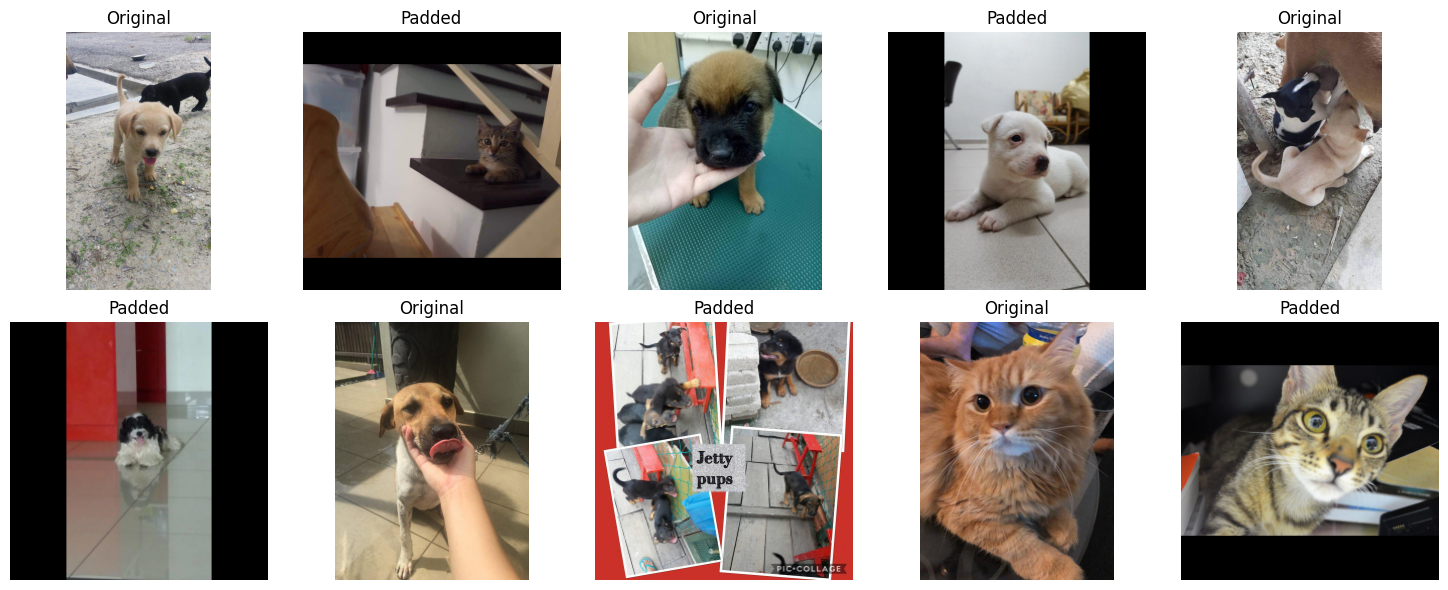

Train dataset: 6938 samples
Validation dataset: 1486 samples
Test dataset: 1488 samples


In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image

# Define constants
DATA_DIR = "train_image"
LABELS_FILE = "train.csv"
IMG_SIZE = (256, 256)  # Target size
BATCH_SIZE = 32

# Load labels
df = pd.read_csv(LABELS_FILE)
df["file_path"] = df["Id"].apply(lambda x: os.path.join(DATA_DIR, f"{x}.jpg"))

# Function for smart resizing with padding
def resize_with_padding(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    if img is None:
        return None  # Skip missing images

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    old_size = img.shape[:2]  # (height, width)

    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    new_size = (int(old_size[1] * ratio), int(old_size[0] * ratio))  # Keep aspect ratio

    img_resized = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)

    # Compute padding
    delta_w = target_size[1] - new_size[0]
    delta_h = target_size[0] - new_size[1]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # Add padding (black background)
    color = [0, 0, 0]  
    img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return img_padded.astype("float32") / 255.0  # Normalize to [0,1]

# Load and preprocess images
X, y = [], []
for img_path, label in zip(df["file_path"], df["Pawpularity"]):
    img_processed = resize_with_padding(img_path, target_size=IMG_SIZE)
    if img_processed is not None:
        X.append(img_processed)
        y.append(label)

X = np.array(X)
y = np.array(y)

# Visualize original vs. padded images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Show 10 images
for i, ax in enumerate(axes.flat):
    original = cv2.imread(df["file_path"][i])
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    padded = X[i]  # Already resized and padded

    ax.imshow(original if i % 2 == 0 else padded)
    ax.set_title("Original" if i % 2 == 0 else "Padded")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Standardize images using Z-score normalization
mean = np.mean(X, axis=(0,1,2,3))
std = np.std(X, axis=(0,1,2,3))
X = (X - mean) / (std + 1e-7)

# Shuffle and split dataset (70% Train, 15% Validation, 15% Test)
indices = np.random.permutation(len(X))
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

print(f"Train dataset: {len(X_train)} samples")
print(f"Validation dataset: {len(X_val)} samples")
print(f"Test dataset: {len(X_test)} samples")

In [3]:
# CNN Model with the Updated Preprocessed Data
from tensorflow import keras
from tensorflow.keras import layers

# Define the CNN model
model_pad = keras.Sequential()

# Input Layer
model_pad.add(layers.Input(shape=(256, 256, 3)))

# First Convolutional Block
model_pad.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_pad.add(layers.BatchNormalization())
model_pad.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model_pad.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_pad.add(layers.BatchNormalization())
model_pad.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Block
model_pad.add(layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same'))
model_pad.add(layers.BatchNormalization())
model_pad.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Block
model_pad.add(layers.Conv2D(filters=128, kernel_size=(7, 7), activation='relu', padding='same'))
model_pad.add(layers.BatchNormalization())
model_pad.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten and Fully Connected Layers
model_pad.add(layers.Flatten())
model_pad.add(layers.Dense(64, activation='relu'))
model_pad.add(layers.Dropout(0.5))  # Prevent overfitting
model_pad.add(layers.Dense(1, activation='linear'))  # Regression output

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_pad.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Show model summary
model_pad.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,556,129 (9.75 MB)

 Trainable params: 2,555,649 (9.75 MB)

 Non-trainable params: 480 (1.88 KB)

In [4]:
# Callback to display loss at each epoch
import time
class PrintLoss(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        t = time.monotonic() - self.time
        print('| Epoch {:2} | Time {:6.2f}s | Train Loss {:.4f} | Val Loss {:.4f} |'
              .format(epoch, t, logs['loss'], logs['val_loss']))

    def on_epoch_begin(self, epoch, logs):
        if epoch == 0:
            self.time = time.monotonic()

# Training Parameters
EPOCHS = 50

# Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model_pad
history = model_pad.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, PrintLoss()]
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - loss: 728.1422 - mae: 20.5152| Epoch  0 | Time 174.82s | Train Loss 666.6212 | Val Loss 459.8091 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 175s 795ms/step - loss: 727.8600 - mae: 20.5106 - val_loss: 459.8091 - val_mae: 16.1824
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 876ms/step - loss: 557.5065 - mae: 17.8256| Epoch  1 | Time 374.08s | Train Loss 582.2581 | Val Loss 476.8079 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 199s 918ms/step - loss: 557.6200 - mae: 17.8272 - val_loss: 476.8079 - val_mae: 16.8030
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - loss: 569.5824 - mae: 17.8677| Epoch  2 | Time 575.01s | Train Loss 571.2785 | Val Loss 446.0953 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 201s 926ms/step - loss: 569.5901 - mae: 17.8679 - val_loss: 446.0953 - val_mae: 15.6423
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - loss: 519.0867 - mae: 17.0976| Epoch  3 | Time 772.59s | Train Loss 540.3904 | Val Loss 436.4621 |
217/217 ━━━━━━━━━━━━━━━━━━━━ 

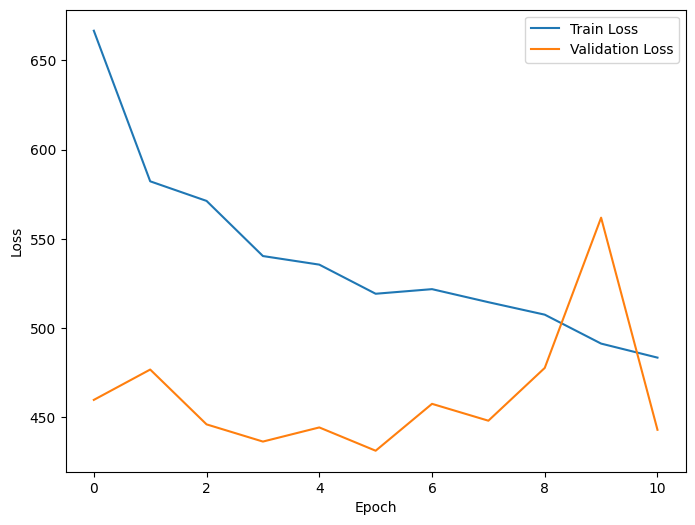

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,6))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'], label="Train Loss")
    plt.plot(hist['epoch'], hist['val_loss'], label="Validation Loss")
    plt.legend()
    plt.show()

# Plot the training history
plot_history(history)

In [6]:
# Evaluate model_pad performance on test dataset
loss, mae = model_pad.evaluate(test_dataset)

print(f"Model Padding Performance on Test Set:")
print(f"Mean Squared Error (MSE): {loss:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - loss: 439.6231 - mae: 15.2207
Model Padding Performance on Test Set:
Mean Squared Error (MSE): 424.9222
Mean Absolute Error (MAE): 15.2099


In [7]:
# Predict Pawpularity scores on test set
y_pred_pad= model_pad.predict(X_test).flatten()  # Flatten to 1D array for easy comparison

# Compare first 10 predictions
for i in range(10):
    print(f"Actual: {y_test[i]:.2f}, Predicted: {y_pred_pad[i]:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step
Actual: 32.00, Predicted: 35.72
Actual: 20.00, Predicted: 35.29
Actual: 31.00, Predicted: 43.33
Actual: 40.00, Predicted: 35.75
Actual: 95.00, Predicted: 37.43
Actual: 48.00, Predicted: 31.73
Actual: 29.00, Predicted: 34.03
Actual: 31.00, Predicted: 40.61
Actual: 46.00, Predicted: 33.59
Actual: 30.00, Predicted: 34.25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1364471..2.0014722].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1238954..2.0014722].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1364471..1.7253354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1364471..2.0642307].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1364471..2.0642307].


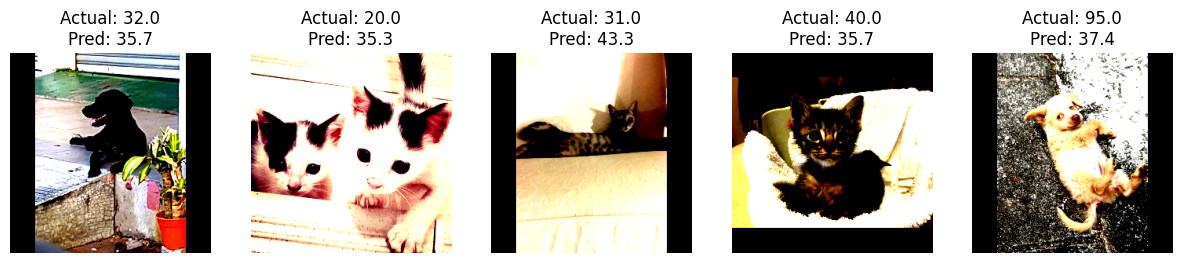

In [8]:
import matplotlib.pyplot as plt

# Show some images with actual vs predicted scores
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i])  # Show test images
    ax.set_title(f"Actual: {y_test[i]:.1f}\nPred: {y_pred_pad[i]:.1f}")
    ax.axis("off")
plt.show()

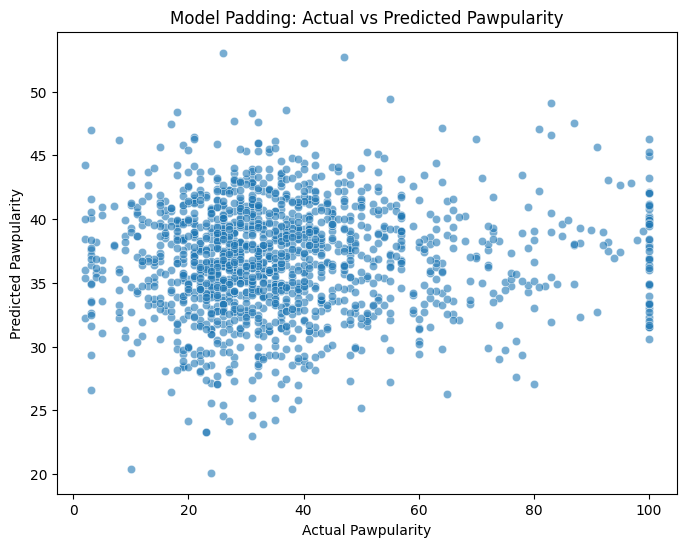

In [9]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_pad, alpha=0.6)
plt.xlabel("Actual Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("Model Padding: Actual vs Predicted Pawpularity")
plt.show()